# Measurement types
In this notebook we
- compare the different ways of taking measurements (point-wise, different convolution types)
- make sure the gradients work in each case

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion_FEniCS")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility

from MyDronePointEval import MyDronePointEval as DronePointEval
from MyDroneUniformEval import MyDroneUniformEval as DroneUniformEval
from MyDroneTruncGaussianEval import MyDroneTruncGaussianEval as DroneTruncGaussianEval
from MyDroneGaussianEval import MyDroneGaussianEval as DroneGaussianEval

import time
tStart_notebook = time.time()

## User settings

In [2]:
n_para = 5
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test = 100 # resolution for 1D plots
n_test_2d = 60 # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

sigma = 0.1
radius = 0.1

meshDim = 50

## Setup

Setup the full-order model. We've imported `FOM_stationary` class as `FOM`.

In [3]:
tStart = time.time()
fom = FOM(meshDim = meshDim)
print("Runtime of this block: {} s".format(time.time()-tStart))

# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

Runtime of this block: 1.6165878772735596 s


Set the prior, just as in the previous notebook:

In [4]:
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)

fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

## Drones

### types of measurements

#### point-wise measurements
The simplest measurement type, we've already seen it in the previous notebook:

$$d(s) = u(x=p(t), s=s)$$

where
- $p$ is the flightpath
- $s$ the time at which we evaluate the measurement

In [5]:
drone_pointwise = DronePointEval(fom)

#### convolution-type: uniform
Another possibility for modelling the measurements is to choose a weighted characteristic function $\Phi(x,y) = \|\Omega_y\|^{-1} \mathbb{1}_{\Omega_y}(x)$ for a measureable domain $\Omega_y \subset \Omega$, $y \in \Omega_y$. In this case a measurement of the state $u$ at time $s$ around position $y$ has the form
$$\ell_y(u,s) := \int_{\Omega} u(x, s) \Phi(x,y) dx = \frac{1}{\|\Omega_y\|} \int_{\Omega_y} u(x, s) dx.$$ 
It is the mean value of a state $u$ over the subdomain $\Omega_y$. 

For our drones, we choose $y$ as the position the flight path $p$ reaches at time $s$, i.e. $y=p(s)$. We then get:
$$d(s) = \ell_{p(s)}(u,s)$$

For our example problem we have chosen 
$$\Omega_y = B_r(y) \cap \Omega,$$
i.e. a ball (actually circle since we are in 2D) around the point $y$ with radius $r$ intersected with the modelling domain $\Omega$. Of course, in discrete forms it's not quite a circle until we look at the limit $h\rightarrow 0$ of infinitely small mesh size, but for a sufficiently refined mesh it's good enough.

In [6]:
drone_uniform = DroneUniformEval(fom, radius=radius)

#### convolution-type: truncated gaussian
The drone flies over the point $y = p(s)$ but then takes a measurement at a random location $x$ with $\|x-y\| \le \sigma$, i.e. a close point but not exactly $y$. The distribution for which $x$ is chosen is described by a truncated Gaussian. We can model this measurement statistically as the expectation of the state under this distribution.

\begin{align}
\Phi(x, y) = \left\{
\begin{array}{ll}
0 & \text{if } \|x-y\| \le 2\sigma \\
C\exp(-\frac{1}{2\sigma^2} \|x-y\|^2) & \text{otherwise}
\end{array}
\right.
\end{align}
where $C$ is chosen such that $\int_{\Omega} \Phi(x, y) dx = 1$ for all $y$. We need the re-scaling such that $\Phi(\cdot, y)$ is indeed a probability densition function.

We define the measurement centered around a point $y \in \Omega$ of a state $u \in H^1(\Omega)$ as 
$$\ell_y(u, s) := \int_{\Omega} u(x, s) \Phi(x, y) dx 
= \int_{\|x-y\| \le 2\sigma} u(x, s) \Phi(x, y) dx 
= \mathbb{E}_{\pi_y}[u(\cdot, s)]
\in \mathbb{R}$$ 
where $\pi_y$ is the probability measure for the probability density function $\Phi(\cdot, y)$.

For our drone measurements we then get:
$$d(s) = \ell_{p(s)}(u, s)$$

In [7]:
drone_truncated = DroneTruncGaussianEval(fom, radius=radius, sigma=sigma, bool_truncate=True)
drone_nontruncated = DroneTruncGaussianEval(fom, radius=radius, sigma=sigma, bool_truncate=False)

**NOTE:** Currently the truncated gaussian is super, super slow. I'm not entirely sure why. We did have it set up wrong in the initial FEniCS version though, that's why I cannot compare to that. Instead of putting you through all this wait time, I'm instead computing the non-truncated Gaussian measurement. We can use it to compare to the other implementation of it below.

#### convolution-type: gaussian
**todo:** write description / explation

In [8]:
tStart = time.time()
drone_gaussian = DroneGaussianEval(fom, sigma=sigma)
print("Gaussian drone initialization time: ", time.time()-tStart, " s.")

Gaussian drone initialization time:  0.00020575523376464844  s.


**Note:** I haven't looked into which boundary conditions we need to set for the heat equation such that we indeed get the correct interpretation of the measurements with this class. Take any measurements with this function with a grain of salt.

## Comparison

The flight path will be the same for each drone, so we can just get it from one of them:

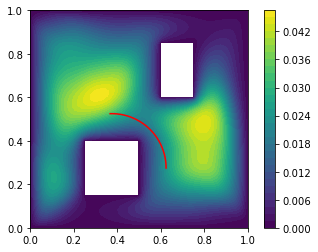

In [9]:
alpha = np.array([0.25, 0.1])
flightpath, grid_t = drone_pointwise.get_trajectory(alpha=alpha)

fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")

In [10]:
data = np.zeros((5, grid_t.shape[0]))
measurement_time = np.zeros(5)
names = ["pointwise", "uniform", "trunc. Gaussian", "not-trunc. Gaussian", "Gaussian, incorr. BC"]

print("Starting: measurements with {} drone".format(names[0]))
tStart = time.time()
data[0,:] = drone_pointwise.measure(state=state, flightpath=flightpath, grid_t=grid_t)
measurement_time[0] = time.time()-tStart

print("Starting: measurements with {} drone".format(names[1]))
tStart = time.time()
data[1,:] = drone_uniform.measure(state=state, flightpath=flightpath, grid_t=grid_t)
measurement_time[1] = time.time()-tStart

print("Starting: measurements with {} drone".format(names[2]))
tStart = time.time()
drone_truncated.is_test = True
data[2,:] = drone_truncated.measure(state=state, flightpath=flightpath, grid_t=grid_t)
measurement_time[2] = time.time()-tStart

# print("Starting: measurements with {} drone".format(names[3]))
# tStart = time.time()
# data[3,:] = drone_nontruncated.measure(state=state, flightpath=flightpath, grid_t=grid_t)
# measurement_time[3] = time.time()-tStart

print("Starting: measurements with {} drone".format(names[4]))
tStart = time.time()
data[4,:] = drone_gaussian.measure(state=state, flightpath=flightpath, grid_t=grid_t)
measurement_time[4] = time.time()-tStart

print(measurement_time)

Starting: measurements with pointwise drone
Starting: measurements with uniform drone
Starting: measurements with trunc. Gaussian drone
Starting: measurements with Gaussian, incorr. BC drone
[7.96914101e-03 3.12720969e+01 3.25205781e+01 0.00000000e+00
 1.52797508e+00]


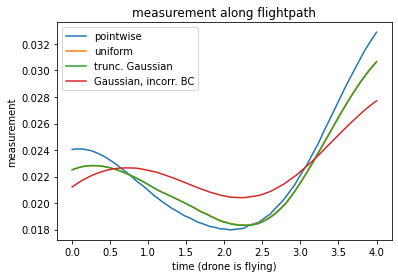

In [11]:
fig, ax = plt.subplots(1,1)

for i in [0, 1, 2, 4]:
    ax.plot(grid_t, data[i, :], label = names[i])
    
ax.set_xlabel("time (drone is flying)")
ax.set_ylabel("measurement")
ax.set_title("measurement along flightpath")
ax.legend()